<a href="https://colab.research.google.com/github/FranciscoMessina00/HomeworkCMRM2023/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMRM Homework Assignment No. 1 (HW1)

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
# import other libraries
!pip install deeplake
!pip install "deeplake[av]"
import deeplake
!pip install sklearn
import sklearn
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.5/574.5 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8

## Question 1

In [2]:
# Import dataset
ds = deeplake.load("hub://activeloop/gtzan-genre")

# 16 bit, 22050 Hz, with 352'800 bit/s
ds.summary()

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre

hub://activeloop/gtzan-genre loaded successfully.



\

Dataset(path='hub://activeloop/gtzan-genre', read_only=True, tensors=['audio', 'genre'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
  audio      audio     (1000, 660000:675808, 1)   None      wav   
  genre   class_label         (1000, 1)          uint32    None   


In [12]:
genre = ds.genre.data()['value']
genre = genre[::100]
print(genre)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [14]:
Fs = 22050
n_samples = 29 * Fs # duration in samples

# Define downsampling factors
sub_train = 10
sub_test = 50

# Extract classes
genre_names = ['pop', 'metal', 'classical', 'rock', 'blues', 'jazz', 'hiphop', 'reggae', 'disco', 'country']

# Indexes
i_train = np.arange(0, len(ds),sub_train)
i_test = np.arange(0, len(ds),sub_test)

genre_train = ds.genre[0:len(ds):sub_train].numpy(aslist = True)
genre_test = ds.genre[10:len(ds):sub_test].numpy(aslist = True)
print(np.shape(genre_train))
print(np.shape(genre_test))

# Extract training set
#for i in tqdm(range(1000)):
audio_train_list = [ds.audio[int(i)].numpy(aslist = True) for i in i_train]
new_audio_train = np.array([])
for i in range(len(audio_train_list)):
  audio_train_list[i] = audio_train_list[i][:n_samples]
  new_audio_train = np.append(new_audio_train, audio_train_list[i])
# as we append the elements, the array will be 1 dimensional, we will reshape
# the array to be 2 dimensional, and we know that the number of elements of the
# train is the length of i_train
num_elements_train = len(i_train)
audio_train = new_audio_train[:num_elements_train * n_samples].reshape(-1, n_samples)

print(np.shape(audio_train))

# Extract test set
#for i in tqdm(range(1000)):
audio_test_list = [ds.audio[int(i)].numpy(aslist = True) for i in i_test]
new_audio_test = np.array([])
for i in range(len(audio_test_list)):
  audio_test_list[i] = audio_test_list[i][:n_samples]
  new_audio_test = np.append(new_audio_test, audio_test_list[i])
# as we append the elements, the array will be 1 dimensional, we will reshape
# the array to be 2 dimensional, and we know that the number of elements of the
# train is the length of i_test
num_elements_test = len(i_test)
audio_test = new_audio_test[:num_elements_test * n_samples].reshape(-1, n_samples)

print(np.shape(audio_test))

(100, 1)
(20, 1)
(100, 639450)
(20, 639450)


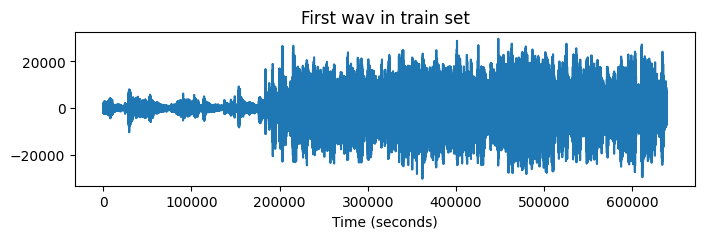

In [15]:
# Plot the first wav in the train set
plt.figure(figsize=(8, 2))
plt.title('First wav in train set')
plt.xlabel('Time (seconds)')
plt.plot(audio_train[0])
plt.show()

## Question 2

In [16]:
# Preprocessing
#def MinMaxScaler(x, feature_range=(-1, 1)):
#  max_value = max(abs(x))
#  return x/max_value
# ho definito anche questa qua in caso il range non è per forza da -1 a 1
#def MinMaxScaler2(x, feature_range=(-1, 1)):
#  range = (feature_range[1] - feature_range[0])/2
#  translate = (feature_range[1] + feature_range[0])/2
#  max_value = max(abs(x))
#  x_scaled = x*range/max_value
#  return x_scaled+translate
from sklearn.preprocessing import MinMaxScaler
#for i in np.arange(audio_train.shape[0]):
#  audio_train[i] = MinMaxScaler(audio_train[i])
scaler = MinMaxScaler(feature_range=(-1, 1))
#       scaler.fit(audio_train)
audio_train = scaler.fit_transform(audio_train)
#for i in np.arange(audio_test.shape[0]):
#  audio_test[i] = sklearn.MinMaxScaler(audio_test[i])
scaler2 = MinMaxScaler(feature_range=(-1, 1))
#       scaler2.fit(audio_test)
audio_test = scaler2.fit_transform(audio_test)

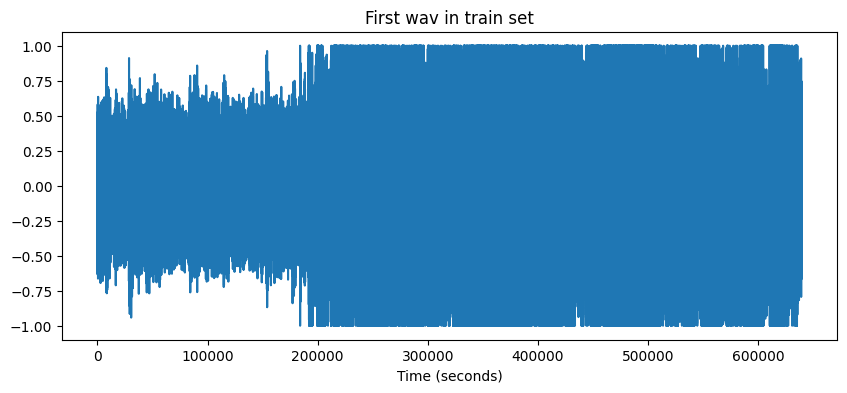

In [18]:
# Plot the first wav in the train set after preprocessing
plt.figure(figsize=(10, 4))
plt.title('First wav in train set')
plt.xlabel('Time (seconds)')
plt.plot(audio_train[0])
plt.show()

In [19]:
# Compute local average
def compute_local_average(x, M):
    """Compute local average of signal

    Args:
        x: Signal
        M: Total length in samples of centric window  used for local average

    Returns:
        local_average: Local average signal
    """

    L = len(x)

    local_average = np.zeros(L)

    for n in range(L):
        a = max(n - M, 0)
        b = min(n + M + 1, L)
        local_average[n] = np.sum(x[a:b]) * (1 / (2*M + 1))
    return local_average

# Compute the principal argument
def principal_argument(x):
    """Principal argument function

    Args:
        x: value (or vector of values)

    Returns:
        y: Principal value of x
    """

    y = np.mod(x + 0.5, 1) - 0.5
    return y

# Compute the Phase-Based Novelty function
def compute_phase_novelty(x, Fs=1, N=1024, H=64, M=40, norm=True, plot=False):
    """Compute phase-based novelty function

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Total length in samples of centric window  used for local average
        norm: Apply max norm (if norm==True)
        plot: plot novelty (if plot==True)

    Returns:
        nov: Phase-based novelty function
        Fs_nov: Novelty rate
    """

    # Compute the STFT
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    # Compute the novelty rate
    Fs_nov = Fs/H

    # Extract the phase and use principal_argument
    phase = np.angle(X)/(2*np.pi)
    # first derivative
    phase_d_1 = principal_argument(np.diff(phase, axis=1))
    # second derivative
    phase_d_2 = principal_argument(np.diff(phase_d_1, axis=1))
    # Accumulation over frequency axis

    nov = np.sum(np.abs(phase_d_2), axis=0)
    #nov = np.sum(phase_d_2, axis=0)
    nov = np.concatenate((nov, np.array([0, 0])))
    # Local average subtraction and half-wave rectification
    if M > 0:
      local_average = compute_local_average(nov, M)
      nov = nov - local_average

    nov[nov < 0] = 0
    # nov = np.concatenate((nov, np.array([0, 0])))
    # Normalization
    if norm:
      max_value = np.max(nov)
      if max_value > 0:
          nov = nov / max_value

    # Plot
    if plot:
      plt.figure(figsize=(12, 4))
      real_t = np.arange(len(nov)) / Fs_nov
      plt.title('First wav novelty')
      plt.xlabel('Time (seconds)')
      plt.plot(real_t, nov)
      plt.show()

    return nov, Fs_nov

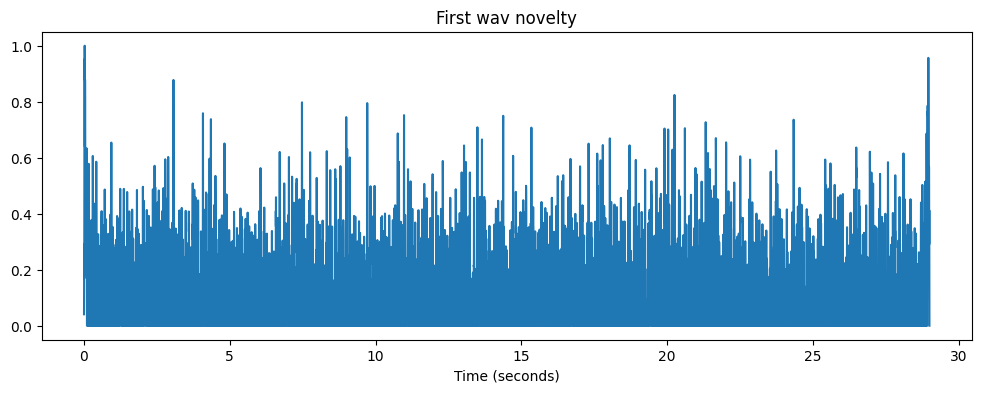

In [20]:
# Test the novelty function on the first wav in the train set
# The hop size cna change the sensitivity on phase changes
nov, Fs_nov = compute_phase_novelty(audio_train[0], Fs=22050, N=1024, H=64, M=40, norm=True, plot=True)

## Question 3

In [56]:
def compute_feature_vector(x, Fs, N=2048, H=128):
    """Compute the feature vector

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size

    Returns:
        f_vector: Feature vector
    """
    # Compute rhythmic features
    # compute novelty function
    novelty, Fs_nov = compute_phase_novelty(x, Fs=Fs, N=N, H=H)
    # compute the standard deviation and the mean of the novelty function
    std_novelty = np.std(novelty)
    mean_novelty = np.mean(novelty)
    # tempogram and zero crossing rate, do I leave the default value or use the same N and H as before?
    tempogram = librosa.feature.tempogram(y=novelty, sr=Fs_nov, hop_length=H, win_length=N)
    zero_cross = librosa.feature.zero_crossing_rate(x, frame_length=N, hop_length=H)
    # compute the standard deviation and the mean of the zero crossing rate
    std_zero_cross = np.std(zero_cross)
    mean_zero_cross = np.mean(zero_cross)

    spectral_flux = librosa.onset.onset_strength(y=novelty, sr=Fs_nov)
    std_spectral_flux = np.std(spectral_flux)
    mean_spectral_flux = np.mean(spectral_flux)

    # tempo
    #tempo = librosa.feature.rhythm.tempo(y=x, sr=Fs_nov)
    # Concatenate numpy arrays
    f_vector = [std_novelty, mean_novelty, std_zero_cross, mean_zero_cross, std_spectral_flux, mean_spectral_flux]

    return f_vector

In [57]:
# Compute feature vector for all the audio files inside the training set
N = 2048
H = 128

train_fvector = []
for x in audio_train:
  train_fvector.append(compute_feature_vector(x, Fs, N=N, H=H))


test_fvector = []
for x in audio_test:
  test_fvector.append(compute_feature_vector(x, Fs, N=N, H=H))


In [58]:
# Check train_fvector and genre_train shapes
print(np.shape(train_fvector))
print(train_fvector[0])
print(np.shape(test_fvector))

(100, 6)
[0.13950469866053158, 0.08773582137776471, 0.025626594579114727, 0.14304558881480184, 0.7440163099107101, 0.6989947213516017]
(20, 6)


## Question 4

In [59]:
# Define model parameters

import pickle
from sklearn import svm

if not os.path.exists('my_model/'):
    os.mkdir('my_model/')

# Train SVC
C=1
path = f'my_model/svc_fkernelgC_{C}_N_{N}_H_{H}'
trained = sklearn.svm.SVC(C=C, kernel='linear').fit(train_fvector, genre_train)
with open(path, 'wb') as file:
    pickle.dump(trained, file)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# Print the accuracy on the training set
predictions = trained.predict(train_fvector)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(genre_train, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 24.00%


## Question 5

In [ ]:
# Classify the test set



In [ ]:
# Print the accuracy


# Plot the confusion matrix

